# Collaborative Filtering with Surprise
---  

## Concept
Surprise is a Python SciKit that comes with various recommender algorithms and similarity metrics to make it easy to build and analyze recommenders.

<!-- <img src="nmf.png" width="600" height="400"> -->

## Loading Libraries
***Implementing the Surprise Library to Model a Recommender System***

In [280]:
# required libs and packages 

import sys
import time # for counting the time for each steps

import pandas as pd
from surprise import Dataset
from surprise import Reader


# import pandas as pd
from surprise import KNNWithMeans, Dataset, Reader
from surprise.model_selection import GridSearchCV
import time
# loading similarity search model
from surprise import KNNWithMeans


from PIL import Image

## Functions of the WorkFlow

In [ ]:


def perform_grid_search_ratings(file_path, model_gscv, sim_options, measures=["rmse", "mae"], cv):
    """
    Function to perform a grid search on KNNWithMeans algorithm for collaborative filtering.

    Parameters:
    - file_path: str, path to the CSV file containing the dataset.
    - sim_options: dict, dictionary of similarity options for KNN.
    - param_grid: dict, grid of hyperparameters for grid search.
    - measures: list, list of evaluation measures.
    - cv: int, number of cross-validation folds.

    Returns:
    - gs: Fitted GridSearchCV object with results.
    - time_elapsed: Time taken for the grid search.
    """
    
    # Load and preprocess the dataset
    df_rating = pd.read_csv(file_path)
    df_rating.rename(columns={'userId': 'user', 'movieId': 'item'}, inplace=True)
    
    # Convert the DataFrame to a Surprise dataset format
    reader = Reader(rating_scale=(df_rating['rating'].min(), df_rating['rating'].max()))
    data = Dataset.load_from_df(df_rating[["user", "item", "rating"]], reader)
    
    # Set default similarity options if not provided
    if sim_options is None:
        sim_options = {
            "name": ["msd", "cosine"],
            "min_support": [3, 4, 5],
            "user_based": [False, True],
        }
    
    # Set default parameter grid if not provided
    # if param_grid is None:
    param_grid = {"sim_options": sim_options}
    
    # Perform grid search
    time_start = time.time()
    gs = GridSearchCV(model_gscv, param_grid, measures=measures, cv=cv)
    gs.fit(data)
    time_elapsed = time.time() - time_start
    
    return gs, time_elapsed

In [140]:
def fun_Recommender(test_user, df_rating, df_movies, model, no_recom):
    """Making a function which gets the user, df_rating, and movies and optimized model
    and return a recommendation list """
    # here we predict the ratings by one user on all the movies. The user is 10
    user_predic = [] # a list which stores the predicted rates
    for  movie in df_rating['item'].unique():
        prediction = model.predict(test_user, movie)
        user_predic.append(prediction.est)
    
    # Get the data for the user and rating and turn them into a panda dataframe
    dict_user = {'movieId': df_rating['item'].unique(), 'rating': user_predic}
    df_user = pd.DataFrame(dict_user)

    
    dict_user = {'movieId': df_rating['item'].unique(), 'rating': user_predic}
    df_user = pd.DataFrame(dict_user)

    # first searching for movies rated by the user
    list_seen_movies = df_rating[df_rating['user'] == user]['item'].tolist()
    
    df_user_recom = df_user.copy()
    # here we set the rating for seen movies by the user to zero
    for i in range(df_user_recom.shape[0]):
        if df_user_recom.loc[i, 'movieId'] in list_seen_movies:
            df_user_recom.loc[i, 'rating'] = 0
    df_user_recom_sorted = df_user_recom.sort_values(by='rating', ascending = False)
    recommendations_movie=df_user_recom_sorted['movieId']
    return df_movies.set_index('movieId').loc[recommendations_movie].head(no_recom)

In [273]:
import requests
from PIL import Image
from io import BytesIO
import os

def get_movie_posters(movie_tmbds, api_key, save_directory='./images'):
    """
    Function to get movie posters' URLs and save the images locally.
    
    Parameters:
    - movie_tmbds: list of int, a list of TMDB movie IDs.
    - api_key: str, TMDB API key.
    - save_directory: str, path to the directory where images will be saved (default is './images').

    Returns:
    - list_poster_url: list of str, list of poster URLs.
    """
    # Ensure the directory for saving images exists
    if not os.path.exists(save_directory):
        os.makedirs(save_directory)

    image_paths = []
    
    for movie_tmbd in movie_tmbds:
        print(f"Fetching poster for movie ID: {movie_tmbd}")
        base_url = f'https://api.themoviedb.org/3/movie/{movie_tmbd}'

        # Send a GET request to TMDB API
        response = requests.get(base_url, params={'api_key': api_key})

        # Check if the request was successful
        if response.status_code == 200:
            data = response.json()
            poster_path = data.get('poster_path')
            if poster_path:
                poster_url = f'https://image.tmdb.org/t/p/w500{poster_path}'
                # list_poster_url.append(poster_url)
                
                # Send a GET request to the image URL
                response_image = requests.get(poster_url)
                image = Image.open(BytesIO(response_image.content))
                
                # Save the image locally
                image_path = os.path.join(save_directory, f"poster_tmbd_{movie_tmbd}.jpg")
                image.save(image_path)
                image_paths.append(image_path)
                print(f"Saved poster for movie ID {movie_tmbd} at {image_path}")
            else:
                print(f"Poster not found for movie ID {movie_tmbd}.")
        else:
            print(f"Failed to fetch movie details for ID {movie_tmbd}. Status code: {response.status_code}")
    
    return image_paths

In [ ]:
def func_image_merger(image_paths, show_type):
    """ It gets in paths of images and merge the images vertically (ver) or horizontally (hor)"""
    # image_paths is a list of paths of images
    # show_type is direction to show the merge image

    # Open images and store them in a list
    images = [Image.open(img_path) for img_path in image_paths]

    # Determine the width and height for the final merged image
    # For horizontal merge
    # calculating the total width width and maximum hight of all images
    total_width = sum(img.width for img in images)
    max_height = max(img.height for img in images)

    # For vertical merge
    # calculating the total hights width and maximum wdith of all images
    total_height = sum(img.height for img in images)
    max_width = max(img.width for img in images)

    # Create a new blank image for horizontal merge
    merged_image_horizontal = Image.new('RGB', (total_width, max_height))

    # Create a new blank image for vertical merge
    merged_image_vertical = Image.new('RGB', (max_width, total_height))

    # Paste images side by side for horizontal merge
    x_offset = 0
    for img in images:
        merged_image_horizontal.paste(img, (x_offset, 0))
        x_offset += img.width

    # Paste images on top of each other for vertical merge
    y_offset = 0
    for img in images:
        merged_image_vertical.paste(img, (0, y_offset))
        y_offset += img.height

# Save the merged images
    merged_image_horizontal.save('./images/merged_image_horizontal.jpg')
    merged_image_vertical.save('./images/merged_image_vertical.jpg')
    
    if show_type == 'hor':
        return merged_image_horizontal.show()
    else:
        return merged_image_vertical.show()


## Reading the Tables: Getting the Data Sets

In [239]:
# load_data.py

# first we read our data set from directroy

df_rating = pd.read_csv('./data/ml-latest-small/ratings.csv')
df_movies = pd.read_csv('./data/ml-latest-small/movies_modified.csv')

df_links = pd.read_csv('./data/ml-latest-small/links.csv')

# we have to rename teh columns label so that they become consistent with labaling known in the Surprise
# in the Surprise, we have lables item, user and rating
df_rating.rename(columns = {'userId': 'user', 'movieId': 'item' }, inplace = True)


# the reader model is defined to change the format of panda dataframe into format defined in the Surprise
reader = Reader(rating_scale=(1, 5))

# Loads Pandas dataframe into a Surprise data set 
data = Dataset.load_from_df(df_rating[["user", "item", "rating"]], reader)
data

## Algorithms Based on K-Nearest Neighbours (k-NN)
The choice of algorithm depends on the technique. 
For the memory-based approaches (info on userId and MovieId), Centered k-NN fits the bill because it is very close to the centered cosine similarity formula and it is available in Surprise as KNNWithMeans.

***To find the similarity, you simply have to configure the function by passing a dictionary as an argument to the recommender function. The dictionary should have the required keys, such as the following:***

***name***: the similarity metric to use. Options are cosine, msd (default), pearson, or pearson_baseline.\
***user_based***: a boolean that tells whether the approach will be user-based or item-based. The default is True, which means the user-based.\
***min_support***: the minimum number of common items needed between users to consider them for similarity. For the item-based approach, this corresponds to the minimum number of common users for two items.

In [38]:
# The recommender function in the below program is configured to use the cosine similarity and to find similar items using the item-based approach
# To use item-based cosine similarity
sim_options = {
    "name": "cosine",
    "user_based": False,  # Compute  similarities between items
}
algo = KNNWithMeans(sim_options=sim_options)

## Testing above Recommneder
First we need to create a ***Trainset from data***. Trainset is built using the same data but ***contains more information about the data***, such as:
***the number of users and items (n_users, n_items) that are used by the algorithm***.\
You can create Trainset either by using the entire data or a part of the data.\
You can also divide the data into folds where some of the data will be used for training and some for testing.

## Note:
Using only one pair of training and testing data is usually not enough. When you split the original dataset into training and testing data, you should create more than one pair to allow for multiple observations with variations in the training in testing data.

Algorithms should be cross-validated using multiple folds. By using different pairs, you’ll see different results given by your recommender. MovieLens 100k provides five different splits of training and testing data: u1.base, u1.test, u2.base, u2.test … u5.base, u5.test, for a 5-fold cross-validation

In [248]:
# A trainset contains all useful data that constitute a training set.
trainingset = data.build_full_trainset() 
print(trainingset)

print("Number of users:", trainingset.n_users)
print("Number of items:", trainingset.n_items)
print("Number of ratings:", trainingset.n_ratings)

Number of users: 610
Number of items: 9724
Number of ratings: 100836


## Training the recommender Model (not optimized)

In [243]:
# training the model algo 

# we have to make a trainset 
trainingset = data.build_full_trainset()

algo.fit(trainingset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


## Saving the Trained Model

In [60]:
with open('./surprise_recommender.pkl', 'wb') as file:
    pickle.dump(algo, file)

In [75]:
with open('./surprise_recommender.pkl', 'rb') as file:
    model = pickle.load(file)

## Making a Recommendation List for a Single user using unoptimzed model

In [251]:
# A test user
test_user = 10
# number of movies to be recommended
no_recom = 5
fun_Recommender(test_user, df_rating, df_movies, model, no_recom)

,Unnamed: 0,title,genres,released_yr
movieId,,,,
132333,8839,Seve,"['Documentary', 'Drama']",2014.0
67618,6999,Strictly Sexual,"['Comedy', 'Drama', 'Romance']",2008.0
8477,5202,"Jetée, La","['Romance', 'Sci-Fi']",1962.0
6818,4590,Come and See (Idi i smotri),"['Drama', 'War']",1985.0
5490,3908,The Big Bus,"['Action', 'Comedy']",1976.0


## Tuning the Algorithm Parameters

Surprise provides a GridSearchCV class analogous to GridSearchCV from scikit-learn.

Using a dict of all parameters, GridSearchCV tries all the combinations of parameters and reports the best parameters for any accuracy measure


In [281]:
# Example usage of function perform_grid_search_ratings
file_path = './data/ml-latest-small/ratings.csv'

sim_options = {
            "name": ["msd", "cosine"],
            "min_support": [3, 4, 5],
            "user_based": [False, True],
        }

measures=["rmse", "mae"]

# using function perform_grid_search_ratings to do gridsearchcv searching for optimized hyperparameters
grid_search_results, time_taken = perform_grid_search_ratings(file_path, KNNWithMeans, sim_options, cv =3)

print("Best RMSE score:", grid_search_results.best_score['rmse'])
print("Best parameters:", grid_search_results.best_params['rmse'])
print("Time taken (seconds):", time_taken)

# getting the optimized parameters
sim_options =gs.best_params["rmse"]['sim_options']
sim_options

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


KeyboardInterrupt: 

## Training the model again using the optimized parameters

We train the model again using optimized parameters and saving the model on the hrad disk

In [231]:
# creating a trainset that contains all useful data that constitute a training set.

# # we have to rename the columns label so that they become consistent with labaling known in the Surprise
df_rating.rename(columns = {'userId': 'user', 'movieId': 'item' }, inplace = True)

# # converting to pd dataframe into data set consistent with the Surprise format
data = Dataset.load_from_df(df_rating[["user", "item", "rating"]], reader)

trainingset = data.build_full_trainset()

model_gscv = KNNWithMeans(sim_options=sim_options)
model_gscv.fit(trainingset)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [232]:
with open('./surprise_recommender_gscv.pkl', 'wb') as file:
    pickle.dump(model_gscv, file)

In [233]:
# reading the saved model
with open('./surprise_recommender_gscv.pkl', 'rb') as file:
    model_gscv = pickle.load(file)

## Recommending Movies unseen by a user



In [282]:
test_user = 10
recom_movies = fun_Recommender(1000, df_rating, df_movies, model_gscv, 5)
# making a list of tmbds
movie_tmbds = df_links[df_links['movieId'].isin(recom_movies.index)]['tmdbId'].tolist()
recom_movies

,Unnamed: 0,title,genres,released_yr
movieId,,,,
25947,5435,Unfaithfully Yours,['Comedy'],1948.0
8477,5202,"Jetée, La","['Romance', 'Sci-Fi']",1962.0
6818,4590,Come and See (Idi i smotri),"['Drama', 'War']",1985.0
3379,2523,On the Beach,['Drama'],1959.0
57502,6667,Cat Soup (Nekojiru-so),"['Adventure', 'Animation', 'Drama', 'Horror']",2001.0


## Getting the Poster of Movies

To get movie posters using the TMDB (The Movie Database) ID in Python, we use requests library.\
TMDB provides an API that can be accessed to get movie details, including poster URLs.

***Explanation***\
***base_url***: The endpoint to get movie details by ID.\
***poster_path***: The path to the poster image is provided in the API response.\
***Poster URL***: Use https://image.tmdb.org/t/p/w500 as the base URL, followed by the poster_path to get a medium-sized image. You can replace w500 with other sizes (w200, w780, etc.) as needed.

In [274]:
# getting the poster images and saving them in a directory 
api_key = '32963fd453f575aa44262db989d926d6'
image_paths = get_movie_posters(movie_tmbds, api_key)

image_paths

Fetching poster for movie ID: 550
Saved poster for movie ID 550 at ./images\poster_tmbd_550.jpg
Fetching poster for movie ID: 299536
Saved poster for movie ID 299536 at ./images\poster_tmbd_299536.jpg
Fetching poster for movie ID: 603
Saved poster for movie ID 603 at ./images\poster_tmbd_603.jpg
List of poster URLs: ['https://image.tmdb.org/t/p/w500/pB8BM7pdSp6B6Ih7QZ4DrQ3PmJK.jpg', 'https://image.tmdb.org/t/p/w500/7WsyChQLEftFiDOVTGkv3hFpyyt.jpg', 'https://image.tmdb.org/t/p/w500/p96dm7sCMn4VYAStA6siNz30G1r.jpg']


['./images\\poster_tmbd_550.jpg',
 './images\\poster_tmbd_299536.jpg',
 './images\\poster_tmbd_603.jpg']

## Merging the Posters of Movies

### Explanation:
***Image.new('RGB', (width, height))***: Creates a new blank image with specified dimensions.\
***paste(img, (x_offset, y_offset))***: Pastes each image at the specified offset.\
Offsets: Used to track where each image should be pasted in the merged image.
### Customization:
You can customize the background color of the new image by passing an additional color parameter, e.g., Image.new('RGB', (width, height), (255, 255, 255)) for a white background.\
Adjust the image_paths to include the paths to the images you want to merge.
This code merges images either horizontally or vertically and saves the merged result to your current working directory.

In [275]:
# 
print(movie_tmbds)
# List of image file paths
# image_paths = [f"./images/poster_tmbd_{movie_tmbd}.jpg" for movie_tmbd in movie_tmbds]

func_image_merger(image_paths, 'hor')


[550, 299536, 603]


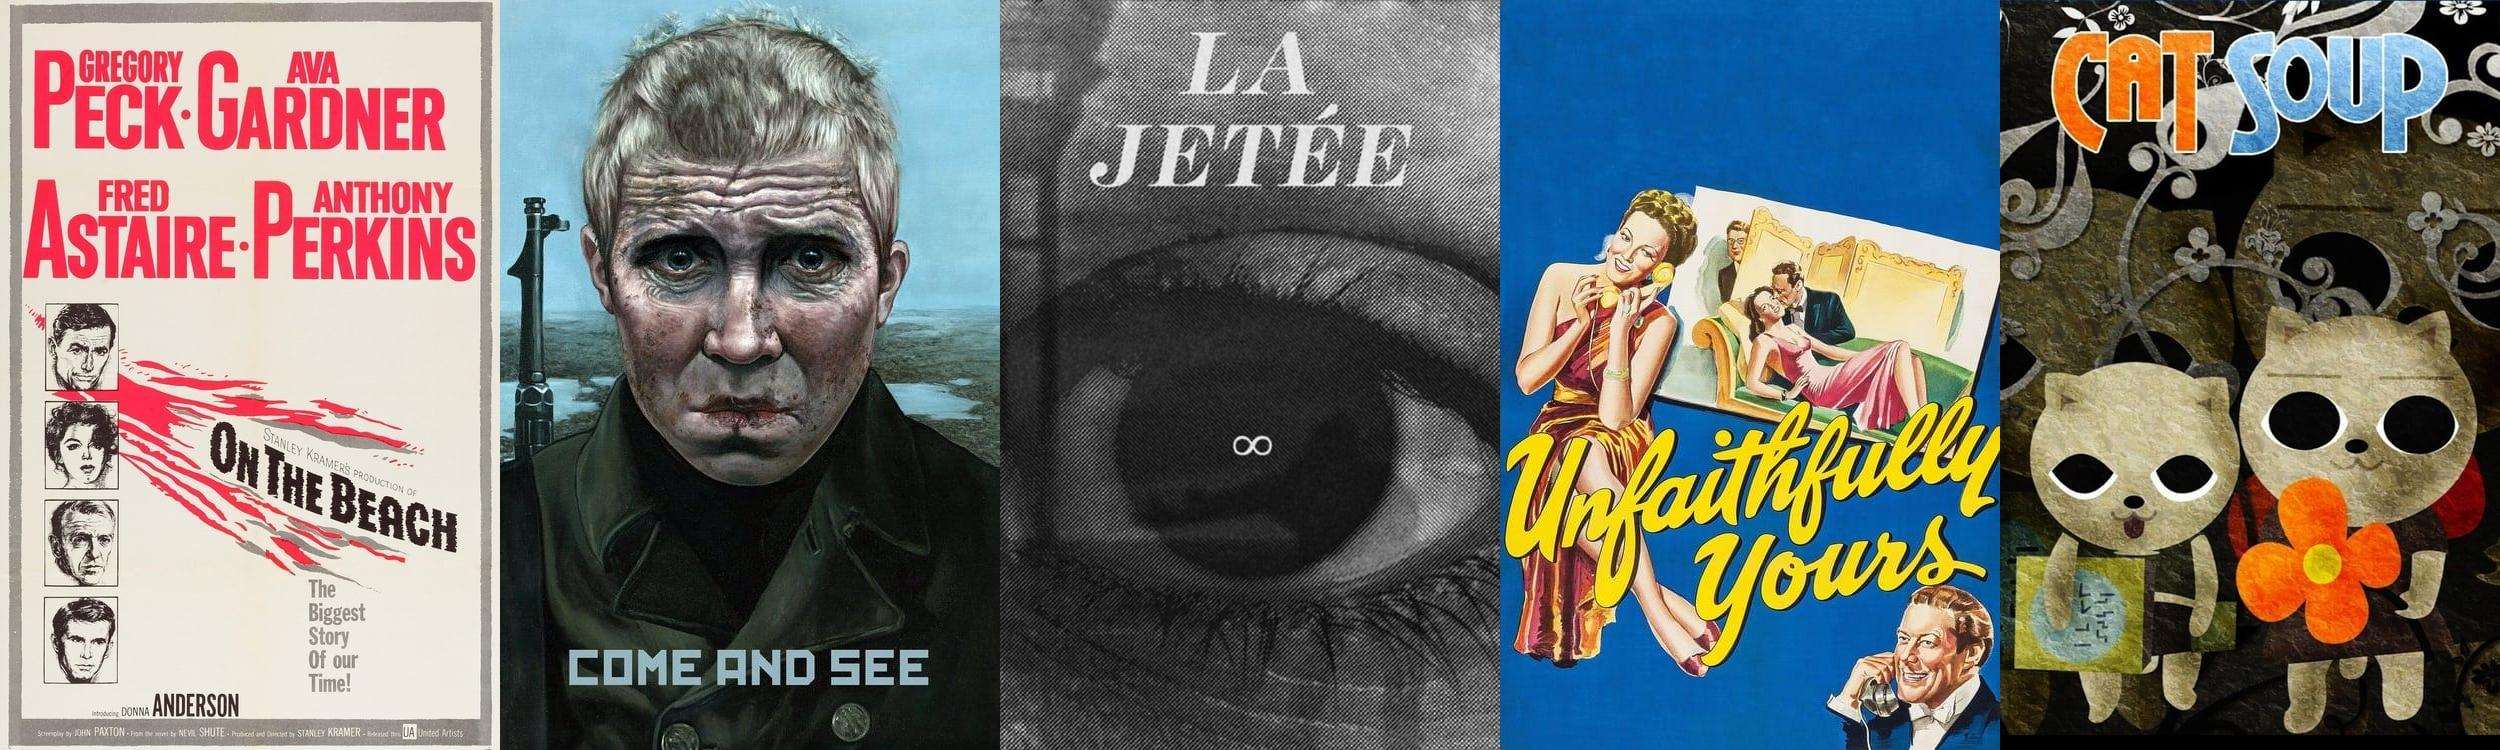

In [267]:
from IPython.display import Image
Image(filename='./images/merged_image_horizontal.jpg')

In [279]:
# # give a zero score to movies the test user has allready seen and rated
# # first searching for movies rated by the test user
# test_user = 10
# list_seen_movies = df_rating[df_rating['user'] == test_user]['item'].tolist()
# len(list_seen_movies)

# df_user_recom = df_user.copy() # 
# # here we set to zero the rating for seen movies by the test user
# for i in range(df_user_recom.shape[0]):
#     if df_user_recom.loc[i, 'movieId'] in list_seen_movies:
#         df_user_recom.loc[i, 'rating'] = 0

In [104]:
# def fun_Recommender(user, df_rating, df_movies, model):
#     """Making a function which gets the user, df_rating, and movies and optimized model
#     and return a recommendation list """
#     # here we predict the ratings by one user on all the movies. The user is 10
#     user_predic = [] # a list which stores the predicted rates
#     for  movie in df_rating['item'].unique():
#         prediction = model.predict(10, movie)
#         user_predic.append(prediction.est)
    
#     # Get the data for the user and rating and turn them into a panda dataframe
#     dict_user = {'movieId': df_rating['item'].unique(), 'rating': user_predic}
#     df_user = pd.DataFrame(dict_user)

    
#     dict_user = {'movieId': df_rating['item'].unique(), 'rating': user_predic}
#     df_user = pd.DataFrame(dict_user)

#     # first searching for movies rated by the user
#     list_seen_movies = df_rating[df_rating['user'] == user]['item'].tolist()
    
#     df_user_recom = df_user.copy()
#     # here we set the rating for seen movies by the user to zero
#     for i in range(df_user_recom.shape[0]):
#         if df_user_recom.loc[i, 'movieId'] in list_seen_movies:
#             df_user_recom.loc[i, 'rating'] = 0
#     df_user_recom_sorted = df_user_recom.sort_values(by='rating', ascending = False)
#     recommendations_movie=df_user_recom_sorted['movieId']
#     return df_movies.set_index('movieId').loc[recommendations_movie]

In [276]:
# # modules to get posters' urls and get images out of them
# import requests

# from PIL import Image
# from io import BytesIO

# list_poster_url = []
# # TMDB API key
# api_key = '32963fd453f575aa44262db989d926d6'

# for movie_tmbd in movie_tmbds:
#     print(movie_tmbd)
# # Base URL for TMDB API
#     base_url = f'https://api.themoviedb.org/3/movie/{movie_tmbd}'

# # Send a GET request to TMDB API
#     response = requests.get(base_url, params={'api_key': api_key})

# # Check if the request was successful
#     if response.status_code == 200:
#         data = response.json()
#         poster_path = data.get('poster_path')
#         if poster_path:
#             poster_url = f'https://image.tmdb.org/t/p/w500{poster_path}'
#             # appending new url to the list of urls
#             list_poster_url.append(poster_url)
#             # Send a GET request to the image URL
#             response_image = requests.get(poster_url)
#              # Convert the content into a bytes stream and open it with Pillow
#             image = Image.open(BytesIO(response_image.content))
#             image.save(f"./images/poster_tmbd_{movie_tmbd}.jpg")
#             # print("Poster URL:", poster_url)
#         else:
#             print("Poster not found for this movie.")
#     else:
#         print("Failed to fetch movie details. Status code:", response.status_code)
# list_poster_url